## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, recall_score, roc_auc_score, roc_curve,r2_score,f1_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import lightgbm as lgb
import pickle
import fancyimpute
from joblib import dump, load
%matplotlib inline

## Read Data

In [0]:
df_app = pd.read_csv('application_train.csv')

In [3]:
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_bureau = pd.read_csv('bureau.csv')

In [5]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [0]:
df_bureau_balance = pd.read_csv('bureau_balance.csv')

In [7]:
df_bureau_balance.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [8]:
df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [9]:
df_bureau.isna().sum()/len(df_bureau['SK_ID_CURR'])

SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_ACTIVE             0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
DAYS_CREDIT_ENDDATE       0.061496
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_MAX_OVERDUE    0.655133
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM            0.000008
AMT_CREDIT_SUM_DEBT       0.150119
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
AMT_ANNUITY               0.714735
dtype: float64

In [10]:
df_bureau.corr()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,1.000000,0.000135,0.000266,0.000283,0.000456,-0.000648,0.001329,-0.000388,0.001179,-0.000790,-0.000304,-0.000014,0.000510,-0.002727
SK_ID_BUREAU,0.000135,1.000000,0.013015,-0.002628,0.009107,0.017890,0.002290,-0.000740,0.007962,0.005732,-0.003986,-0.000499,0.019398,0.001799
DAYS_CREDIT,0.000266,0.013015,1.000000,-0.027266,0.225682,0.875359,-0.014724,-0.030460,0.050883,0.135397,0.025140,-0.000383,0.688771,0.005676
CREDIT_DAY_OVERDUE,0.000283,-0.002628,-0.027266,1.000000,-0.007352,-0.008637,0.001249,0.002756,-0.003292,-0.002355,-0.000345,0.090951,-0.018461,-0.000339
DAYS_CREDIT_ENDDATE,0.000456,0.009107,0.225682,-0.007352,1.000000,0.248825,0.000577,0.113683,0.055424,0.081298,0.095421,0.001077,0.248525,0.000475
DAYS_ENDDATE_FACT,-0.000648,0.017890,0.875359,-0.008637,0.248825,1.000000,0.000999,0.012017,0.059096,0.019609,0.019476,-0.000332,0.751294,0.006274
AMT_CREDIT_MAX_OVERDUE,0.001329,0.002290,-0.014724,0.001249,0.000577,0.000999,1.000000,0.001523,0.081663,0.014007,-0.000112,0.015036,-0.000749,0.001578
CNT_CREDIT_PROLONG,-0.000388,-0.000740,-0.030460,0.002756,0.113683,0.012017,0.001523,1.000000,-0.008345,-0.001366,0.073805,0.000002,0.017864,-0.000465
AMT_CREDIT_SUM,0.001179,0.007962,0.050883,-0.003292,0.055424,0.059096,0.081663,-0.008345,1.000000,0.683419,0.003756,0.006342,0.104629,0.049146
AMT_CREDIT_SUM_DEBT,-0.000790,0.005732,0.135397,-0.002355,0.081298,0.019609,0.014007,-0.001366,0.683419,1.000000,-0.018215,0.008046,0.141235,0.025507


## Exploratory Data Analysis

In [0]:
def plot_dist_grid(data,row,col,cols):
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(14,18))
    i = 0
    for ax in axes.flatten():
        sns.distplot(data[cols[i]].dropna(),ax= ax,kde = False)
        i += 1
    
    # Display the figure object    
    fig
    plt.tight_layout()

In [0]:
def plot_count_grid(data,row,col,cols):
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(16,4))
    i = 0
    for ax in axes.flatten():
        sns.countplot(x = cols[i],ax= ax,data = data)
        i += 1
    
    # Display the figure object    
    fig
    plt.tight_layout()

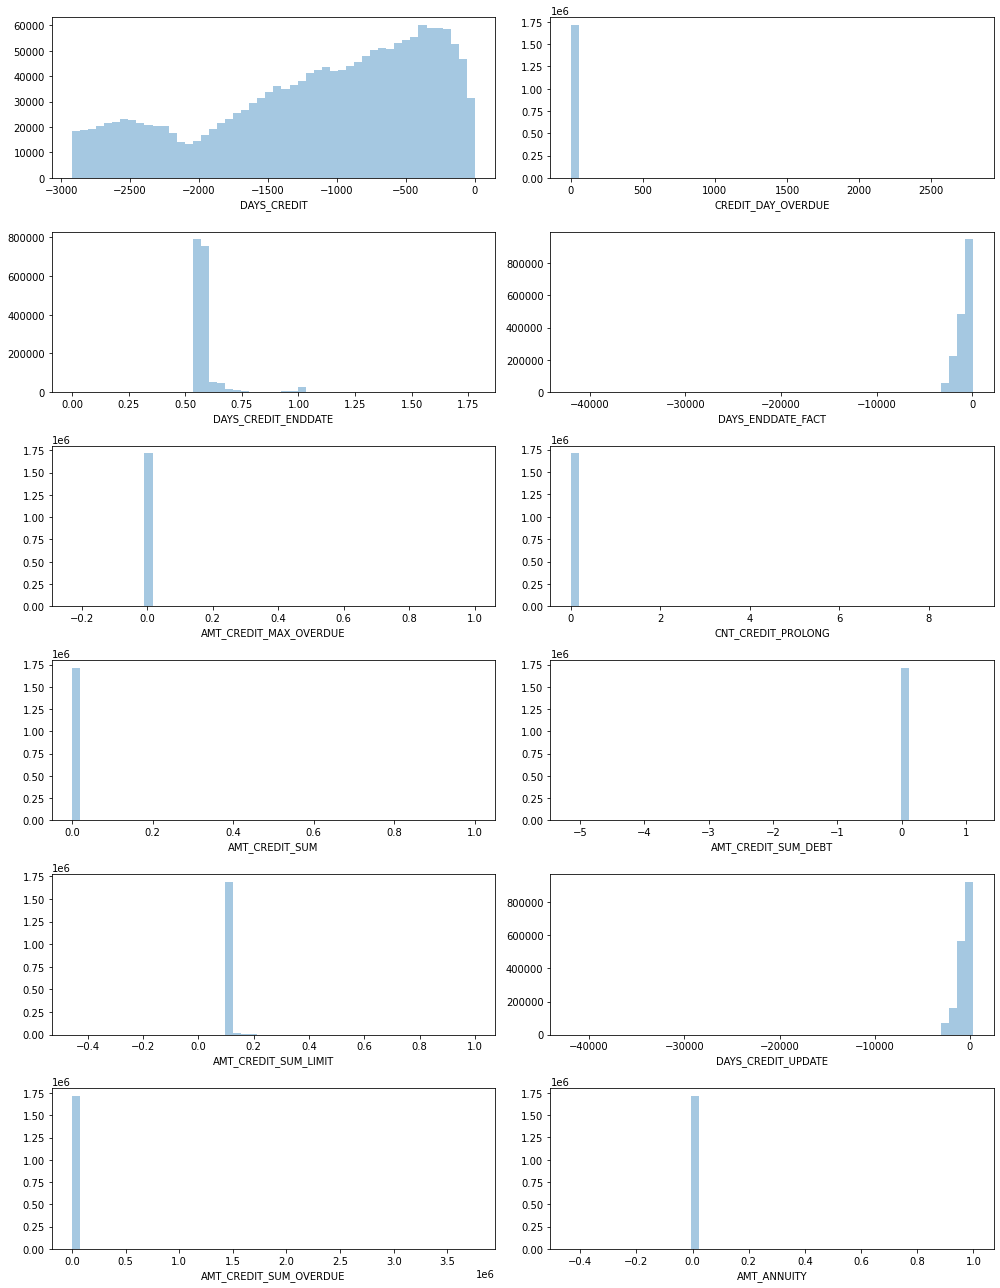

In [29]:
plot_dist_grid(df_bureau,6,2,['DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
                    'AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT',
                   'AMT_CREDIT_SUM_LIMIT','DAYS_CREDIT_UPDATE','AMT_CREDIT_SUM_OVERDUE','AMT_ANNUITY'])

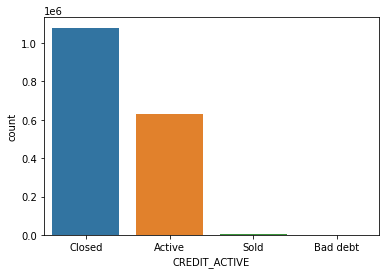

In [30]:
sns.countplot(x = 'CREDIT_ACTIVE',data = df_bureau)

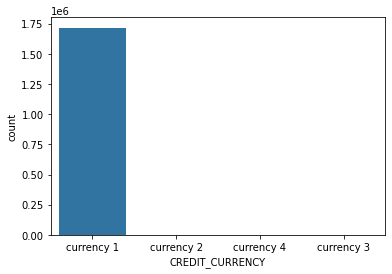

In [31]:
sns.countplot(x = 'CREDIT_CURRENCY',data = df_bureau)

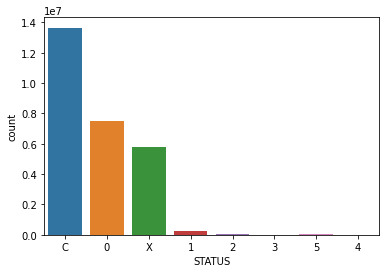

In [33]:
sns.countplot(x = 'STATUS',data = df_bureau_balance)

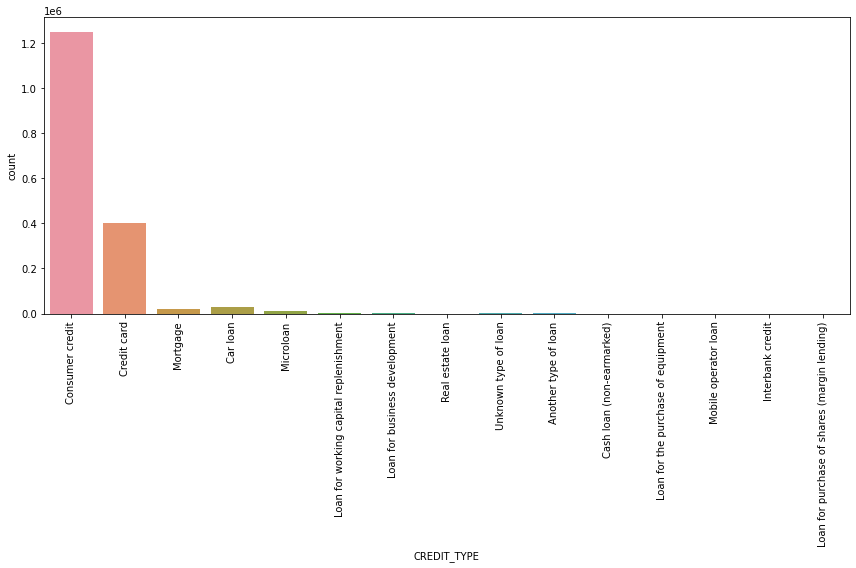

In [32]:
plt.figure(figsize = (12,8))
sns.countplot(x = 'CREDIT_TYPE',data = df_bureau)
plt.xticks(rotation = 90)
plt.tight_layout()

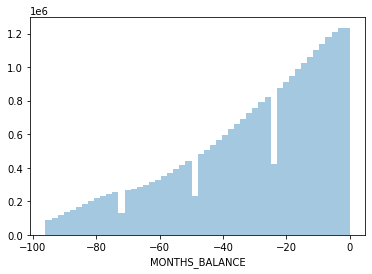

In [34]:
sns.distplot(df_bureau_balance['MONTHS_BALANCE'],kde = False)

## Imputation

**Due to high correlation we can use 'DAYS_CREDIT' and 'DAYS_CREDIT_UPDATE' to impute 'DAYS_ENDDATE_FACT'**

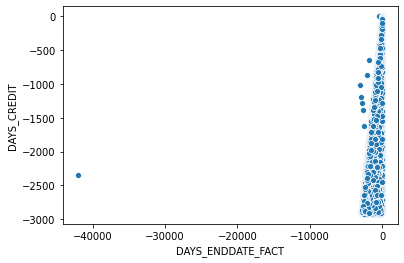

In [11]:
sns.scatterplot(x = 'DAYS_ENDDATE_FACT',y = 'DAYS_CREDIT',data = df_bureau)

In [12]:
model = linear_model.LinearRegression()
model.fit(X = df_bureau.drop(['AMT_ANNUITY','DAYS_CREDIT_ENDDATE'],axis =1).dropna(how = 'any')[['DAYS_CREDIT','DAYS_CREDIT_UPDATE'	]],
          y = df_bureau.drop(['AMT_ANNUITY','DAYS_CREDIT_ENDDATE'],axis =1).dropna(how = 'any')['DAYS_ENDDATE_FACT'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
r2_score(df_bureau.drop(['AMT_ANNUITY','DAYS_CREDIT_ENDDATE'],axis =1).dropna(how = 'any')['DAYS_ENDDATE_FACT'],
        model.predict(df_bureau.drop(['AMT_ANNUITY','DAYS_CREDIT_ENDDATE'],axis =1).dropna(how = 'any')[['DAYS_CREDIT','DAYS_CREDIT_UPDATE'	]]))

0.8632645368638452

In [0]:
df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'].isna(),'DAYS_ENDDATE_FACT'] = \
                                        model.predict(df_bureau[df_bureau['DAYS_ENDDATE_FACT'].isna()][['DAYS_CREDIT','DAYS_CREDIT_UPDATE']])

**We will use MICE to impute the remaining attributes. Before running MICE, we have to create dummy variables and scale the data**

In [0]:
def create_dummies(data,col_list):
    
    for col_name in col_list:
        
        drop_first = False
        if len(data[col_name].value_counts().index) == 2:
            drop_first = True
            
        tempdf = pd.get_dummies(data[col_name],drop_first = drop_first)
        
        if not drop_first:
            tempdf.columns = [col_name +'_' + str(col) for col in tempdf.columns]
        else:
            tempdf.columns = [col_name]
            
        data = data.drop(col_name,axis = 1).join(tempdf)
        
    return data

In [0]:
df_temp = create_dummies(df_bureau,['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE'])

In [17]:
df_temp.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.000000,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,-9.281606,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,-4.924327,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,NaN,-4.924327,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,-314.889492,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_temp.drop(['SK_ID_CURR','SK_ID_BUREAU'],axis = 1))
df_temp = pd.DataFrame(np_scaled, columns=df_temp.drop(['SK_ID_CURR','SK_ID_BUREAU'],axis = 1).columns, index=df_temp.drop(['SK_ID_CURR','SK_ID_BUREAU'],axis = 1).index)

In [0]:
MICE_imputer = fancyimpute.IterativeImputer()

In [20]:
df_temp = pd.DataFrame(data = MICE_imputer.fit_transform(df_temp),columns=df_temp.columns, index=df_temp.index)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [21]:
df_temp.head()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,0.829911,0.0,0.572039,0.992927,-0.000034,0.0,0.000156,0.026919,0.110302,0.0,0.988114,0.000019,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.928816,0.0,0.588801,0.996335,-0.000011,0.0,0.000385,0.027899,0.114659,0.0,0.990737,0.000196,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.930527,0.0,0.581335,0.996438,0.000003,0.0,0.000794,0.028799,0.111090,0.0,0.990832,0.000159,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.930527,0.0,0.650004,0.996438,-0.000056,0.0,0.000154,0.027763,0.115594,0.0,0.990832,0.000115,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.784736,0.0,0.590467,0.989088,0.000670,0.0,0.004615,0.032415,0.112421,0.0,0.990713,0.001019,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_bureau['AMT_ANNUITY'] = df_temp['AMT_ANNUITY']
df_bureau['AMT_CREDIT_MAX_OVERDUE'] = df_temp['AMT_CREDIT_MAX_OVERDUE']
df_bureau['AMT_CREDIT_SUM_DEBT'] = df_temp['AMT_CREDIT_SUM_DEBT']
df_bureau['AMT_CREDIT_SUM_LIMIT'] = df_temp['AMT_CREDIT_SUM_LIMIT']
df_bureau['DAYS_CREDIT_ENDDATE'] = df_temp['DAYS_CREDIT_ENDDATE']
df_bureau['AMT_CREDIT_SUM'] = df_temp['AMT_CREDIT_SUM']

In [0]:
df_temp = pd.get_dummies(df_app)

In [0]:
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_temp.drop(['SK_ID_CURR'],axis = 1))
df_temp = pd.DataFrame(np_scaled, columns=df_temp.drop(['SK_ID_CURR'],axis = 1).columns, index=df_temp.drop(['SK_ID_CURR'],axis = 1).index)

In [25]:
df_temp = pd.DataFrame(data = MICE_imputer.fit_transform(df_temp),columns=df_temp.columns, index=df_temp.index)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

In [0]:
df_temp['SK_ID_CURR'] = df_app['SK_ID_CURR']
df_app = df_temp

## Functions

In [0]:
def agg_numeric(df,grp,agg_list):
    return df.groupby(grp,as_index=False).agg(agg_list).reset_index()

In [0]:
def categorical(df,grp,numeric_df):
    categorical_df = pd.get_dummies(df.select_dtypes('object'))
    categorical_df[grp] = numeric_df[grp]
    return categorical_df

In [0]:
def df_merge(df,df_cat,merge_on):
    merged_df = df.merge(df_cat,on=merge_on,how = 'left')
    return merged_df

In [0]:
def col_renamer(data,group_var):

    columns = [group_var]

    # Iterate through the variables names
    for var in list(data.columns.levels[0]):
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in list(data.columns.levels[1][:-1]):
                # Make a new column name for the variable and stat
                columns.append('%s_%s' % (var, stat))
    
    data.columns = columns
    
    return data

## Bureau

**Let's prepare the Bureau dataset before it is merged with application_train**

In [39]:
num_bureau = (df_bureau.drop(columns = ['SK_ID_BUREAU']).pipe(agg_numeric, grp='SK_ID_CURR',agg_list = ['count','mean'])
             .pipe(col_renamer,group_var = 'SK_ID_CURR'))
num_bureau.head()

,SK_ID_CURR,DAYS_CREDIT_count,DAYS_CREDIT_mean,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_mean,DAYS_CREDIT_ENDDATE_count,DAYS_CREDIT_ENDDATE_mean,DAYS_ENDDATE_FACT_count,DAYS_ENDDATE_FACT_mean,AMT_CREDIT_MAX_OVERDUE_count,AMT_CREDIT_MAX_OVERDUE_mean,CNT_CREDIT_PROLONG_count,CNT_CREDIT_PROLONG_mean,AMT_CREDIT_SUM_count,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_DEBT_count,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_LIMIT_count,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_OVERDUE_count,AMT_CREDIT_SUM_OVERDUE_mean,DAYS_CREDIT_UPDATE_count,DAYS_CREDIT_UPDATE_mean,AMT_ANNUITY_count,AMT_ANNUITY_mean
0,100001,7,-735.000000,7,0.0,7,0.575253,7,-506.468606,7,0.000032,7,0.0,7,0.000355,7,0.027407,7,0.110831,7,0.0,7,-93.142857,7,0.000030
1,100002,8,-874.000000,8,0.0,8,0.587211,8,-591.349121,8,0.000009,8,0.0,8,0.000185,8,0.027005,8,0.112901,8,0.0,8,-499.875000,8,0.000007
2,100003,4,-1400.750000,4,0.0,4,0.566695,4,-898.554497,4,0.000000,4,0.0,4,0.000435,4,0.026919,4,0.149075,4,0.0,4,-816.000000,4,-0.000162
3,100004,2,-867.000000,2,0.0,2,0.567459,2,-532.500000,2,-0.000014,2,0.0,2,0.000162,2,0.026919,2,0.110810,2,0.0,2,-532.000000,2,-0.000013
4,100005,3,-190.666667,3,0.0,3,0.580124,3,5.166712,3,-0.000053,3,0.0,3,0.000374,3,0.028003,3,0.110810,3,0.0,3,-54.333333,3,0.000012


In [40]:
cat_bureau = (df_bureau.pipe(categorical, grp='SK_ID_CURR',numeric_df = num_bureau)
             .pipe(agg_numeric, grp='SK_ID_CURR',agg_list = ['sum','mean','max','min'])
             .pipe(col_renamer,group_var = 'SK_ID_CURR'))
cat_bureau.head()

,SK_ID_CURR,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Active_max,CREDIT_ACTIVE_Active_min,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Bad debt_max,CREDIT_ACTIVE_Bad debt_min,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Closed_max,CREDIT_ACTIVE_Closed_min,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_ACTIVE_Sold_max,CREDIT_ACTIVE_Sold_min,CREDIT_CURRENCY_currency 1_sum,CREDIT_CURRENCY_currency 1_mean,CREDIT_CURRENCY_currency 1_max,CREDIT_CURRENCY_currency 1_min,CREDIT_CURRENCY_currency 2_sum,CREDIT_CURRENCY_currency 2_mean,CREDIT_CURRENCY_currency 2_max,CREDIT_CURRENCY_currency 2_min,CREDIT_CURRENCY_currency 3_sum,CREDIT_CURRENCY_currency 3_mean,CREDIT_CURRENCY_currency 3_max,CREDIT_CURRENCY_currency 3_min,CREDIT_CURRENCY_currency 4_sum,CREDIT_CURRENCY_currency 4_mean,CREDIT_CURRENCY_currency 4_max,CREDIT_CURRENCY_currency 4_min,CREDIT_TYPE_Another type of loan_sum,CREDIT_TYPE_Another type of loan_mean,CREDIT_TYPE_Another type of loan_max,CREDIT_TYPE_Another type of loan_min,CREDIT_TYPE_Car loan_sum,CREDIT_TYPE_Car loan_mean,CREDIT_TYPE_Car loan_max,...,CREDIT_TYPE_Interbank credit_sum,CREDIT_TYPE_Interbank credit_mean,CREDIT_TYPE_Interbank credit_max,CREDIT_TYPE_Interbank credit_min,CREDIT_TYPE_Loan for business development_sum,CREDIT_TYPE_Loan for business development_mean,CREDIT_TYPE_Loan for business development_max,CREDIT_TYPE_Loan for business development_min,CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,CREDIT_TYPE_Loan for purchase of shares (margin lending)_max,CREDIT_TYPE_Loan for purchase of shares (margin lending)_min,CREDIT_TYPE_Loan for the purchase of equipment_sum,CREDIT_TYPE_Loan for the purchase of equipment_mean,CREDIT_TYPE_Loan for the purchase of equipment_max,CREDIT_TYPE_Loan for the purchase of equipment_min,CREDIT_TYPE_Loan for working capital replenishment_sum,CREDIT_TYPE_Loan for working capital replenishment_mean,CREDIT_TYPE_Loan for working capital replenishment_max,CREDIT_TYPE_Loan for working capital replenishment_min,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Microloan_max,CREDIT_TYPE_Microloan_min,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mobile operator loan_max,CREDIT_TYPE_Mobile operator loan_min,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Mortgage_max,CREDIT_TYPE_Mortgage_min,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Real estate loan_max,CREDIT_TYPE_Real estate loan_min,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean,CREDIT_TYPE_Unknown type of loan_max,CREDIT_TYPE_Unknown type of loan_min
0,100001.0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100002.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100003.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100004.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100005.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
bureau = df_merge(num_bureau,cat_bureau,'SK_ID_CURR')
bureau.head()

,SK_ID_CURR,DAYS_CREDIT_count,DAYS_CREDIT_mean,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_mean,DAYS_CREDIT_ENDDATE_count,DAYS_CREDIT_ENDDATE_mean,DAYS_ENDDATE_FACT_count,DAYS_ENDDATE_FACT_mean,AMT_CREDIT_MAX_OVERDUE_count,AMT_CREDIT_MAX_OVERDUE_mean,CNT_CREDIT_PROLONG_count,CNT_CREDIT_PROLONG_mean,AMT_CREDIT_SUM_count,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_DEBT_count,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_LIMIT_count,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_OVERDUE_count,AMT_CREDIT_SUM_OVERDUE_mean,DAYS_CREDIT_UPDATE_count,DAYS_CREDIT_UPDATE_mean,AMT_ANNUITY_count,AMT_ANNUITY_mean,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Active_max,CREDIT_ACTIVE_Active_min,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Bad debt_max,CREDIT_ACTIVE_Bad debt_min,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Closed_max,CREDIT_ACTIVE_Closed_min,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_ACTIVE_Sold_max,...,CREDIT_TYPE_Interbank credit_sum,CREDIT_TYPE_Interbank credit_mean,CREDIT_TYPE_Interbank credit_max,CREDIT_TYPE_Interbank credit_min,CREDIT_TYPE_Loan for business development_sum,CREDIT_TYPE_Loan for business development_mean,CREDIT_TYPE_Loan for business development_max,CREDIT_TYPE_Loan for business development_min,CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,CREDIT_TYPE_Loan for purchase of shares (margin lending)_max,CREDIT_TYPE_Loan for purchase of shares (margin lending)_min,CREDIT_TYPE_Loan for the purchase of equipment_sum,CREDIT_TYPE_Loan for the purchase of equipment_mean,CREDIT_TYPE_Loan for the purchase of equipment_max,CREDIT_TYPE_Loan for the purchase of equipment_min,CREDIT_TYPE_Loan for working capital replenishment_sum,CREDIT_TYPE_Loan for working capital replenishment_mean,CREDIT_TYPE_Loan for working capital replenishment_max,CREDIT_TYPE_Loan for working capital replenishment_min,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Microloan_max,CREDIT_TYPE_Microloan_min,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mobile operator loan_max,CREDIT_TYPE_Mobile operator loan_min,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Mortgage_max,CREDIT_TYPE_Mortgage_min,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Real estate loan_max,CREDIT_TYPE_Real estate loan_min,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean,CREDIT_TYPE_Unknown type of loan_max,CREDIT_TYPE_Unknown type of loan_min
0,100001,7,-735.000000,7,0.0,7,0.575253,7,-506.468606,7,0.000032,7,0.0,7,0.000355,7,0.027407,7,0.110831,7,0.0,7,-93.142857,7,0.000030,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100002,8,-874.000000,8,0.0,8,0.587211,8,-591.349121,8,0.000009,8,0.0,8,0.000185,8,0.027005,8,0.112901,8,0.0,8,-499.875000,8,0.000007,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100003,4,-1400.750000,4,0.0,4,0.566695,4,-898.554497,4,0.000000,4,0.0,4,0.000435,4,0.026919,4,0.149075,4,0.0,4,-816.000000,4,-0.000162,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100004,2,-867.000000,2,0.0,2,0.567459,2,-532.500000,2,-0.000014,2,0.0,2,0.000162,2,0.026919,2,0.110810,2,0.0,2,-532.000000,2,-0.000013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100005,3,-190.666667,3,0.0,3,0.580124,3,5.166712,3,-0.000053,3,0.0,3,0.000374,3,0.028003,3,0.110810,3,0.0,3,-54.333333,3,0.000012,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
bureau.shape

(305811, 117)

In [43]:
bureau.isna().sum().sum()

0

## Bureau Balance

**Let's prepare the Bureau dataset before it is merged with bureau**

In [44]:
num_bureau_bal = (df_bureau_balance.pipe(agg_numeric, grp='SK_ID_BUREAU',agg_list = ['count','mean'])
             .pipe(col_renamer,group_var = 'SK_ID_BUREAU'))
num_bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE_count,MONTHS_BALANCE_mean
0,5001709,97,-48.0
1,5001710,83,-41.0
2,5001711,4,-1.5
3,5001712,19,-9.0
4,5001713,22,-10.5


In [45]:
cat_bureau_bal = (df_bureau_balance.pipe(categorical, grp='SK_ID_BUREAU',numeric_df = num_bureau_bal)
             .pipe(agg_numeric, grp='SK_ID_BUREAU',agg_list = ['sum','mean','max','min'])
             .pipe(col_renamer,group_var = 'SK_ID_BUREAU'))
cat_bureau_bal['SK_ID_BUREAU'] = cat_bureau_bal['SK_ID_BUREAU'].astype('int')
cat_bureau_bal.head()

,SK_ID_BUREAU,STATUS_0_sum,STATUS_0_mean,STATUS_0_max,STATUS_0_min,STATUS_1_sum,STATUS_1_mean,STATUS_1_max,STATUS_1_min,STATUS_2_sum,STATUS_2_mean,STATUS_2_max,STATUS_2_min,STATUS_3_sum,STATUS_3_mean,STATUS_3_max,STATUS_3_min,STATUS_4_sum,STATUS_4_mean,STATUS_4_max,STATUS_4_min,STATUS_5_sum,STATUS_5_mean,STATUS_5_max,STATUS_5_min,STATUS_C_sum,STATUS_C_mean,STATUS_C_max,STATUS_C_min,STATUS_X_sum,STATUS_X_mean,STATUS_X_max,STATUS_X_min
0,5001709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
1,5001710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
2,5001711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
3,5001712,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
4,5001713,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0


In [46]:
bureau_bal = df_merge(num_bureau_bal,cat_bureau_bal,'SK_ID_BUREAU')
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE_count,MONTHS_BALANCE_mean,STATUS_0_sum,STATUS_0_mean,STATUS_0_max,STATUS_0_min,STATUS_1_sum,STATUS_1_mean,STATUS_1_max,STATUS_1_min,STATUS_2_sum,STATUS_2_mean,STATUS_2_max,STATUS_2_min,STATUS_3_sum,STATUS_3_mean,STATUS_3_max,STATUS_3_min,STATUS_4_sum,STATUS_4_mean,STATUS_4_max,STATUS_4_min,STATUS_5_sum,STATUS_5_mean,STATUS_5_max,STATUS_5_min,STATUS_C_sum,STATUS_C_mean,STATUS_C_max,STATUS_C_min,STATUS_X_sum,STATUS_X_mean,STATUS_X_max,STATUS_X_min
0,5001709,97,-48.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
1,5001710,83,-41.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
2,5001711,4,-1.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
3,5001712,19,-9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
4,5001713,22,-10.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0


In [47]:
bureau_bal.shape

(817395, 35)

In [48]:
bureau_bal.isna().sum().sum()

0

In [0]:
bureau_bal = df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_bal, on = 'SK_ID_BUREAU', how = 'left')

In [50]:
bureau_bal.shape

(1716428, 36)

In [51]:
bureau_bal = (bureau_bal.drop(columns = ['SK_ID_BUREAU']).pipe(agg_numeric, grp='SK_ID_CURR',agg_list = ['count','mean'])
             .pipe(col_renamer,group_var = 'SK_ID_CURR'))
bureau_bal.head()

,SK_ID_CURR,MONTHS_BALANCE_count_count,MONTHS_BALANCE_count_mean,MONTHS_BALANCE_mean_count,MONTHS_BALANCE_mean_mean,STATUS_0_sum_count,STATUS_0_sum_mean,STATUS_0_mean_count,STATUS_0_mean_mean,STATUS_0_max_count,STATUS_0_max_mean,STATUS_0_min_count,STATUS_0_min_mean,STATUS_1_sum_count,STATUS_1_sum_mean,STATUS_1_mean_count,STATUS_1_mean_mean,STATUS_1_max_count,STATUS_1_max_mean,STATUS_1_min_count,STATUS_1_min_mean,STATUS_2_sum_count,STATUS_2_sum_mean,STATUS_2_mean_count,STATUS_2_mean_mean,STATUS_2_max_count,STATUS_2_max_mean,STATUS_2_min_count,STATUS_2_min_mean,STATUS_3_sum_count,STATUS_3_sum_mean,STATUS_3_mean_count,STATUS_3_mean_mean,STATUS_3_max_count,STATUS_3_max_mean,STATUS_3_min_count,STATUS_3_min_mean,STATUS_4_sum_count,STATUS_4_sum_mean,STATUS_4_mean_count,STATUS_4_mean_mean,STATUS_4_max_count,STATUS_4_max_mean,STATUS_4_min_count,STATUS_4_min_mean,STATUS_5_sum_count,STATUS_5_sum_mean,STATUS_5_mean_count,STATUS_5_mean_mean,STATUS_5_max_count,STATUS_5_max_mean,STATUS_5_min_count,STATUS_5_min_mean,STATUS_C_sum_count,STATUS_C_sum_mean,STATUS_C_mean_count,STATUS_C_mean_mean,STATUS_C_max_count,STATUS_C_max_mean,STATUS_C_min_count,STATUS_C_min_mean,STATUS_X_sum_count,STATUS_X_sum_mean,STATUS_X_mean_count,STATUS_X_mean_mean,STATUS_X_max_count,STATUS_X_max_mean,STATUS_X_min_count,STATUS_X_min_mean
0,100001,7,24.571429,7,-11.785714,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,0.0,7,1.000,7,1.000,7,1.000,7,1.000,7,0.000,7,0.000,7,0.000,7,0.000
1,100002,8,13.750000,8,-21.875000,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.0,8,0.875,8,0.875,8,0.875,8,0.875,8,0.125,8,0.125,8,0.125,8,0.125
2,100003,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
3,100004,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,100005,3,7.000000,3,-3.000000,3,1.0,3,1.0,3,1.0,3,1.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.0,3,0.000,3,0.000,3,0.000,3,0.000,3,0.000,3,0.000,3,0.000,3,0.000


In [52]:
bureau_bal.shape

(305811, 69)

## Merge Application, Bureau and Bureau Balance

In [53]:
df_merged = df_merge(df_app,bureau,'SK_ID_CURR')
df_merged.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,CREDIT_TYPE_Interbank credit_sum,CREDIT_TYPE_Interbank credit_mean,CREDIT_TYPE_Interbank credit_max,CREDIT_TYPE_Interbank credit_min,CREDIT_TYPE_Loan for business development_sum,CREDIT_TYPE_Loan for business development_mean,CREDIT_TYPE_Loan for business development_max,CREDIT_TYPE_Loan for business development_min,CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,CREDIT_TYPE_Loan for purchase of shares (margin lending)_max,CREDIT_TYPE_Loan for purchase of shares (margin lending)_min,CREDIT_TYPE_Loan for the purchase of equipment_sum,CREDIT_TYPE_Loan for the purchase of equipment_mean,CREDIT_TYPE_Loan for the purchase of equipment_max,CREDIT_TYPE_Loan for the purchase of equipment_min,CREDIT_TYPE_Loan for working capital replenishment_sum,CREDIT_TYPE_Loan for working capital replenishment_mean,CREDIT_TYPE_Loan for working capital replenishment_max,CREDIT_TYPE_Loan for working capital replenishment_min,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Microloan_max,CREDIT_TYPE_Microloan_min,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mobile operator loan_max,CREDIT_TYPE_Mobile operator loan_min,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Mortgage_max,CREDIT_TYPE_Mortgage_min,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Real estate loan_max,CREDIT_TYPE_Real estate loan_min,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean,CREDIT_TYPE_Unknown type of loan_max,CREDIT_TYPE_Unknown type of loan_min
0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,0.217302,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.024700,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,0.301145,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0.727773,0.357678,0.095900,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,0.285714,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.515394,0.650190,0.814130,0.111316,0.088600,0.976309,0.747595,0.042756,0.078546,0.147259,0.218090,0.223752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,0.158333,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,0.5,0.5,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,0.652734,0.760751,0.625749,0.111957,0.088468,0.976185,0.746629,0.041982,0.078083,0.147473,0.218953,0.223781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [54]:
df = df_merge(df_merged,bureau_bal,'SK_ID_CURR')
df.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,STATUS_3_sum_count,STATUS_3_sum_mean,STATUS_3_mean_count,STATUS_3_mean_mean,STATUS_3_max_count,STATUS_3_max_mean,STATUS_3_min_count,STATUS_3_min_mean,STATUS_4_sum_count,STATUS_4_sum_mean,STATUS_4_mean_count,STATUS_4_mean_mean,STATUS_4_max_count,STATUS_4_max_mean,STATUS_4_min_count,STATUS_4_min_mean,STATUS_5_sum_count,STATUS_5_sum_mean,STATUS_5_mean_count,STATUS_5_mean_mean,STATUS_5_max_count,STATUS_5_max_mean,STATUS_5_min_count,STATUS_5_min_mean,STATUS_C_sum_count,STATUS_C_sum_mean,STATUS_C_mean_count,STATUS_C_mean_mean,STATUS_C_max_count,STATUS_C_max_mean,STATUS_C_min_count,STATUS_C_min_mean,STATUS_X_sum_count,STATUS_X_sum_mean,STATUS_X_mean_count,STATUS_X_mean_mean,STATUS_X_max_count,STATUS_X_max_mean,STATUS_X_min_count,STATUS_X_min_mean
0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,0.217302,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.024700,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,...,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.875,8.0,0.875,8.0,0.875,8.0,0.875,8.0,0.125,8.0,0.125,8.0,0.125,8.0,0.125
1,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,0.301145,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0.727773,0.357678,0.095900,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,0.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,0.285714,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.391304,0.0,0.0,0.0,0.0,0.0,0.0,0.515394,0.650190,0.814130,0.111316,0.088600,0.976309,0.747595,0.042756,0.078546,0.147259,0.218090,0.223752,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,0.158333,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,0.5,0.5,0.739130,0.0,0.0,0.0,0.0,0.0,0.0,0.652734,0.760751,0.625749,0.111957,0.088468,0.976185,0.746629,0.041982,0.078083,0.147473,0.218953,0.223781,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,0.825268,0.519522,0.146422,1.0,1.0,0.0,1.0,0.0,0.0,0.000000,0.5,0.5,0.478261,0.0,0.0,0.0,0.0,1.0,1.0,0.647034,0.377472,0.660233,0.110784,0.088979,0.976157,0.747832,0.046136,0.080763,0.146872,0.217192,0.224982,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [55]:
df.shape

(307511, 430)

## Data Cleaning

**The merged data file needs to be cleaned**

In [0]:
na_summary = df.isna().sum()/len(df['TARGET'])

In [57]:
mis_val_df = pd.concat([df.isna().sum(),na_summary],axis = 1)
mis_val_df

,0,1
TARGET,0,0.000000
CNT_CHILDREN,0,0.000000
AMT_INCOME_TOTAL,0,0.000000
AMT_CREDIT,0,0.000000
AMT_ANNUITY,0,0.000000
...,...,...
STATUS_X_mean_mean,215280,0.700073
STATUS_X_max_count,44020,0.143149
STATUS_X_max_mean,215280,0.700073
STATUS_X_min_count,44020,0.143149


In [58]:
mis_val_df = mis_val_df.rename(columns = {0 : 'Missing Values', 1 : 'Proportion of Missing Values'})
mis_val_df.head()

,Missing Values,Proportion of Missing Values
TARGET,0,0.0
CNT_CHILDREN,0,0.0
AMT_INCOME_TOTAL,0,0.0
AMT_CREDIT,0,0.0
AMT_ANNUITY,0,0.0


In [59]:
mis_val_df.sort_values(by = 'Proportion of Missing Values',ascending=False,inplace=True)
mis_val_df.head()

,Missing Values,Proportion of Missing Values
STATUS_X_min_mean,215280,0.700073
STATUS_2_sum_mean,215280,0.700073
STATUS_4_max_mean,215280,0.700073
STATUS_4_mean_mean,215280,0.700073
STATUS_4_sum_mean,215280,0.700073


In [0]:
drop_cols = mis_val_df['Proportion of Missing Values'][mis_val_df['Proportion of Missing Values'] > 0.15].index

In [0]:
df.drop(drop_cols,axis=1,inplace = True)

In [0]:
sf = fancyimpute.SimpleFill(fill_method='median')
df_final = pd.DataFrame(data = sf.fit_transform(df),columns=df.columns, index=df.index)

In [64]:
df_final.shape

(307511, 396)

## Holdout Method

In [0]:
X = df_final.drop(['SK_ID_CURR', 'TARGET'],axis = 1)
y = df_final['TARGET']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Data Modeling

### Gradient Boosting

In [76]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', n_jobs = -1, random_state = 50)
        
# Train the model
model.fit(X_train, y_train, verbose = 200)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
               objective='binary', random_state=50, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [0]:
pred = model.predict(X_test)

In [78]:
print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     84841
         1.0       0.95      0.63      0.76      7413

    accuracy                           0.97     92254
   macro avg       0.96      0.82      0.87     92254
weighted avg       0.97      0.97      0.96     92254

Accuracy Score:  0.9677303965139723
Recall Score:  0.6336166194523135
AUC 0.8152701383231793


Predicted,0.0,1.0,All
True,,,
0.0,84580,261,84841
1.0,2716,4697,7413
All,87296,4958,92254


#### Optimization

In [0]:
param_grid = {'n_estimators': [10000],
              'objective': ['binary'],
              'class_weight' : ['balanced'],
              'reg_alpha':[0.1,0.2,0.3,0.4],
              'reg_lambda':[0.1,0.2,0.3,0.4],
              'subsample':[0.6,0.8,0.95]
              'learning_rate': [0.03,0.05,0.15]
            }

gs = GridSearchCV(lgb.LGBMClassifier(reg_alpha = 1.0, reg_lambda = 0.8,subsample = 0.8,learning_rate = 0.02,random_state = 50), param_grid, scoring='recall',cv = 3,verbose=1,n_jobs = 4)
gs.fit(X_train, y_train)

In [0]:
print(gs.best_score_)

In [0]:
for hps, values in gs.best_params_.items():
    print(f"{hps}: {values}")

In [86]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.02, 
                                   reg_alpha = 1.0, reg_lambda = 0.8, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
# Train the model
model.fit(X_train, y_train, verbose = 200)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.02, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=50,
               reg_alpha=1.0, reg_lambda=0.8, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

In [87]:
pred = model.predict(X_test)

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     84841
         1.0       0.75      0.72      0.73      7413

    accuracy                           0.96     92254
   macro avg       0.86      0.85      0.86     92254
weighted avg       0.96      0.96      0.96     92254

Accuracy Score:  0.9579747219632753
Recall Score:  0.7239983812221773
AUC 0.8512084172821557


Predicted,0.0,1.0,All
True,,,
0.0,83010,1831,84841
1.0,2046,5367,7413
All,85056,7198,92254


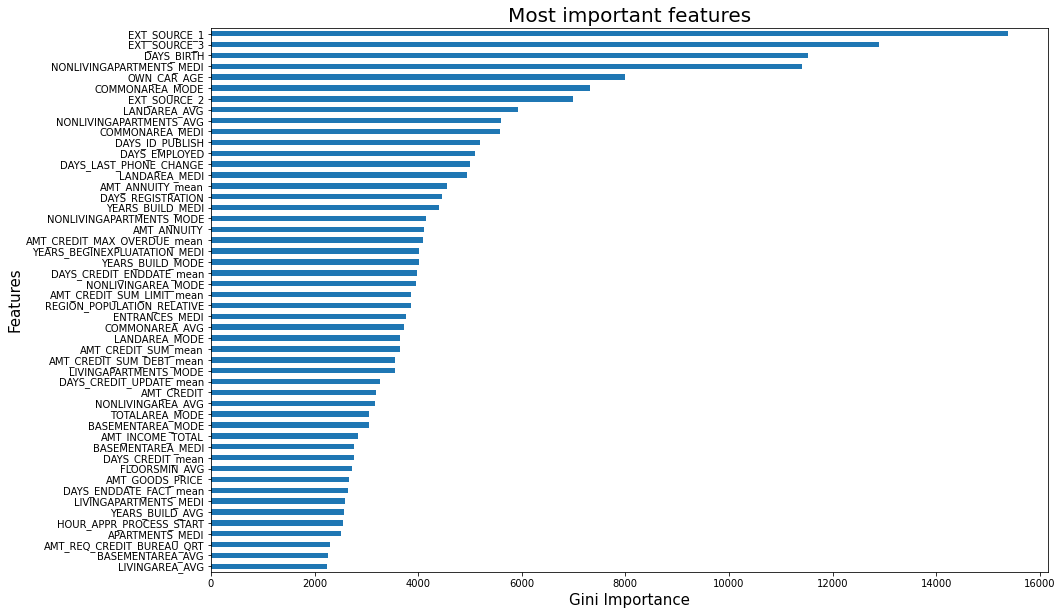

In [88]:
model_ranks = pd.Series(model.feature_importances_, index=X_train.columns, name='Importance')
model_ranks.sort_values(ascending=True,inplace=True)
top_features = model_ranks[-50:]
plt.figure(figsize=(15,10))
ax = top_features.plot(kind='barh')
ax.set_xlabel('Gini Importance', fontsize = 15)
ax.set_ylabel('Features', fontsize = 15)
ax.set_title('Most important features', fontsize = 20)
plt.show();

### Random Forest

In [89]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [90]:
pred = rfc.predict(X_test)

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       1.00      0.04      0.07      7413

    accuracy                           0.92     92254
   macro avg       0.96      0.52      0.51     92254
weighted avg       0.93      0.92      0.89     92254

Accuracy Score:  0.9225182647906865
Recall Score:  0.03588290840415486
AUC 0.5179355608250544


Predicted,0.0,1.0,All
True,,,
0.0,84840,1,84841
1.0,7147,266,7413
All,91987,267,92254


#### Optimization

In [101]:
param_grid = {'min_samples_split': [10000],
              'max_features': ['sqrt','log2'],
              'class_weight' : [{0:1,1:17},{0:1,1:5}],
              'max_depth':[5,25],
              'n_estimators':[400]
            }

gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1',cv = 6,verbose=1,n_jobs = 4)
gs.fit(X_train, y_train)

Fitting 6 folds for each of 8 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 36.2min finished


GridSearchCV(cv=6, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [102]:
for hps, values in gs.best_params_.items():
    print(f"{hps}: {values}")

class_weight: {0: 1, 1: 17}
max_depth: 25
max_features: sqrt
min_samples_split: 10000
n_estimators: 400


In [103]:
pred = gs.best_estimator_.predict(X_test)

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.98      0.37      0.53     84841
         1.0       0.11      0.92      0.20      7413

    accuracy                           0.41     92254
   macro avg       0.55      0.64      0.37     92254
weighted avg       0.91      0.41      0.51     92254

Accuracy Score:  0.4108114553298502
Recall Score:  0.9210845811412384
AUC 0.6436554080491967


Predicted,0.0,1.0,All
True,,,
0.0,31071,53770,84841
1.0,585,6828,7413
All,31656,60598,92254


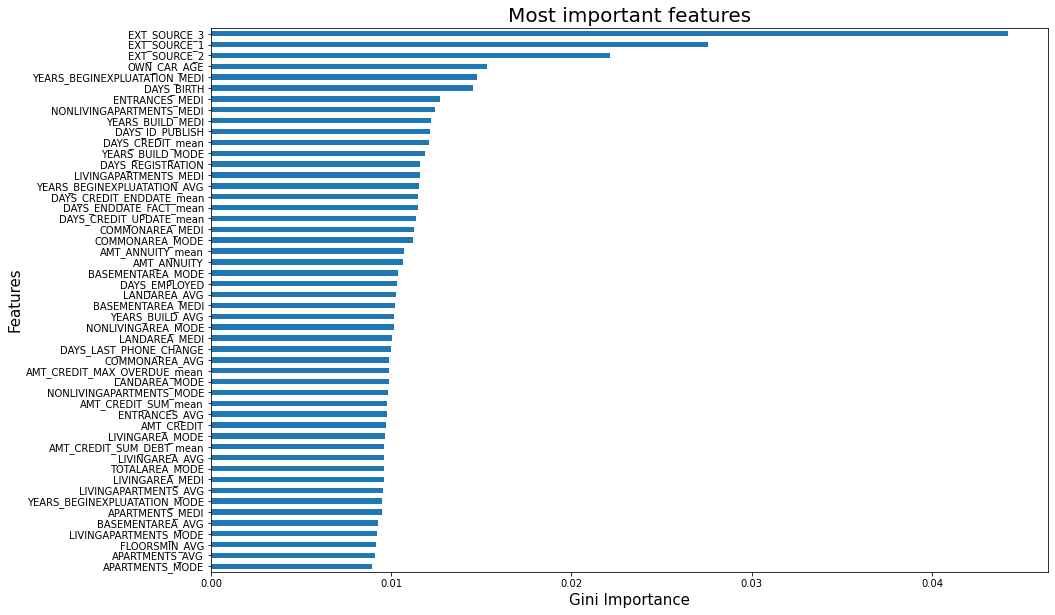

In [104]:
model_ranks = pd.Series(rfc.feature_importances_, index=X_train.columns, name='Importance')
model_ranks.sort_values(ascending=True,inplace=True)
top_features = model_ranks[-50:]
plt.figure(figsize=(15,10))
ax = top_features.plot(kind='barh')
ax.set_xlabel('Gini Importance', fontsize = 15)
ax.set_ylabel('Features', fontsize = 15)
ax.set_title('Most important features', fontsize = 20)
plt.show();

### Logistic Regression

In [95]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
pred = lr.predict(X_test)

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.37      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.64      0.50      0.48     92254
weighted avg       0.88      0.92      0.88     92254

Accuracy Score:  0.9195915624254775
Recall Score:  0.0009442870632672333
AUC 0.5004014230073588


Predicted,0.0,1.0,All
True,,,
0.0,84829,12,84841
1.0,7406,7,7413
All,92235,19,92254


#### Optimization

In [98]:
param_grid = {'C': [0.01,0.01,0.1],
              'dual': [False],
              'penalty' : ['l1'],
              'solver':['liblinear'],
              'class_weight':[{0:1,1:11},{0:1,1:5}]
            }

gs = GridSearchCV(LogisticRegression(random_state=42), param_grid, scoring='recall',cv = 6,verbose=1,n_jobs = 4)
gs.fit(X_train, y_train)

Fitting 6 folds for each of 6 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 54.3min finished


GridSearchCV(cv=6, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [0.01, 0.01, 0.1],
                         'class_weight': [{0: 1, 1: 11}, {0: 1, 1: 5}],
                         'dual': [False], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [99]:
for hps, values in gs.best_params_.items():
    print(f"{hps}: {values}")

C: 0.1
class_weight: {0: 1, 1: 11}
dual: False
penalty: l1
solver: liblinear


In [100]:
pred = gs.best_estimator_.predict(X_test)

print(classification_report(y_test,pred))
print("Accuracy Score: ",accuracy_score(y_test,pred))
print("Recall Score: ",recall_score(y_test,pred))
print("AUC",roc_auc_score(y_test,pred))
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     84841
         1.0       0.21      0.73      0.32      7413

    accuracy                           0.75     92254
   macro avg       0.59      0.74      0.59     92254
weighted avg       0.91      0.75      0.81     92254

Accuracy Score:  0.7521083096667895
Recall Score:  0.7323620666396871
AUC 0.7430978541965423


Predicted,0.0,1.0,All
True,,,
0.0,63956,20885,84841
1.0,1984,5429,7413
All,65940,26314,92254
